C:\Users\E124796\AppData\Local\Temp\2\ipykernel_4420\3799192012.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y.append(data[i + look_back])



Treinando modelo com 100 neurônios...
1/1 [==============================] - 0s 71ms/step
Neurônios: 100, MAPE: 0.05%

Treinando modelo com 200 neurônios...
1/1 [==============================] - 0s 69ms/step
Neurônios: 200, MAPE: 0.05%

Treinando modelo com 300 neurônios...
1/1 [==============================] - 0s 72ms/step
Neurônios: 300, MAPE: 0.06%

Comparação entre Valores Reais e Previstos:
               Valor Real  Valor Previsto
AM_REFERENCIA                            
2024-07-01         161149   188440.328125
2024-08-01         169700   170703.718750
2024-09-01         180721   169940.875000
2024-10-01         173691   178557.968750
2024-11-01         179036   178489.718750
2024-12-01         182626   184196.937500


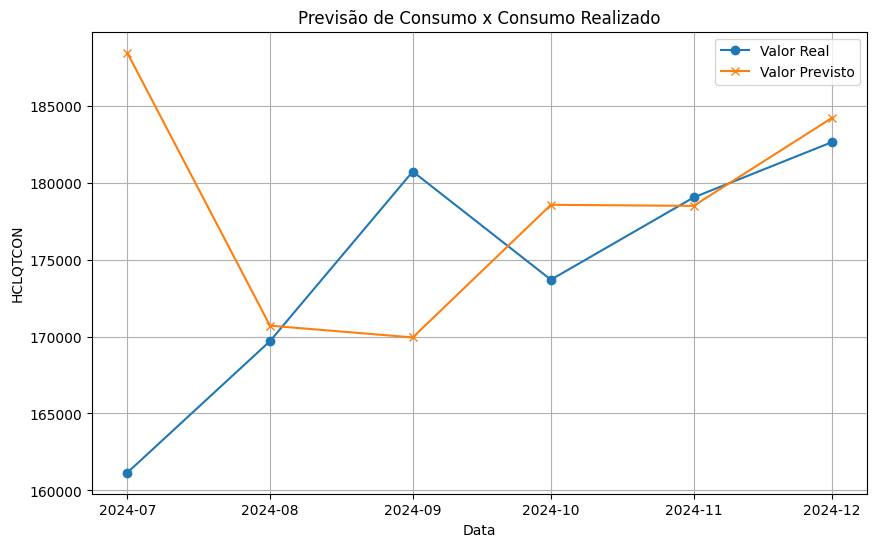

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import tensorflow as tf

# Função personalizada para calcular o MAPE como loss
def mape_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)  # Convertendo y_true para float32
    return tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100

# Função para realizar a previsão e plotar o gráfico
def prever_e_plotar(caminho_arquivo):
    # Carregando os dados do CSV
    df = pd.read_csv(caminho_arquivo, sep=';')

    # Convertendo AM_REFERENCIA para datetime
    df['AM_REFERENCIA'] = pd.to_datetime(df['AM_REFERENCIA'], format='%Y%m')

    # Agregando os dados por AM_REFERENCIA, somando HCLQTCON
    df_aggregated = df.groupby('AM_REFERENCIA')['HCLQTCON'].sum().reset_index()

    # Ordenando por data
    df_aggregated = df_aggregated.sort_values(by='AM_REFERENCIA')

    # Definindo a série temporal
    ts = df_aggregated.set_index('AM_REFERENCIA')['HCLQTCON']

    # Dividindo os dados em treino e teste
    train = ts['2015-01':'2023-12']
    test = ts['2024-01':'2024-12']

    # Função para criar datasets
    def create_dataset(data, look_back=1):
        X, Y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:(i + look_back)])
            Y.append(data[i + look_back])
        return np.array(X), np.array(Y)

    look_back = 6  # Definindo look_back como 6
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # Verificando se há dados suficientes após o look_back
    if len(X_train) == 0 or len(X_test) == 0:
        raise ValueError("O look_back é maior que o número de dados disponíveis. Reduza o look_back.")

    # Reshape input to be [samples, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

    # Testando diferentes números de neurônios
    neurons_list = [100, 200, 300]
    best_mape = float('inf')
    best_model = None
    best_predictions = None

    for neurons in neurons_list:
        print(f"\nTreinando modelo com {neurons} neurônios...")
        # Construindo o modelo MLP
        model = Sequential()
        model.add(Dense(neurons, input_dim=look_back, activation='relu'))  # Primeira camada densa
        model.add(Dense(neurons // 2, activation='relu'))  # Segunda camada densa com metade dos neurônios
        model.add(Dense(neurons // 2, activation='relu'))  # Terceira camada densa com metade dos neurônios
        model.add(Dense(25, activation='relu'))  # Camada densa com ativação ReLU
        model.add(Dense(1))  # Camada de saída
        optimizer = Adam(learning_rate=0.01)  # Otimizador com learning_rate ajustável
        model.compile(loss=mape_loss, optimizer=optimizer)  # Usando MAPE como loss
        model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=0)  # Aumentando o número de épocas

        # Fazendo previsões
        predictions = model.predict(X_test)

        # Avaliando o modelo com MAPE
        mape_value = mape(Y_test, predictions.flatten())
        print(f'Neurônios: {neurons}, MAPE: {mape_value:.2f}%')

        # Verificando se é o melhor modelo
        if mape_value < best_mape:
            best_mape = mape_value
            best_model = model
            best_predictions = predictions.flatten()

    # Criando um DataFrame para comparar valores reais e previstos
    comparison_df = pd.DataFrame({
        'Valor Real': test[look_back:],
        'Valor Previsto': best_predictions
    })

    # Exibindo os valores reais e previstos
    print("\nComparação entre Valores Reais e Previstos:")
    print(comparison_df)

    # Plotando o gráfico de previsão x realizado
    plt.figure(figsize=(10, 6))
    plt.plot(test.index[look_back:], test[look_back:], label='Valor Real', marker='o')
    plt.plot(test.index[look_back:], best_predictions, label='Valor Previsto', marker='x')
    plt.title('Previsão de Consumo x Consumo Realizado')
    plt.xlabel('Data')
    plt.ylabel('HCLQTCON')
    plt.legend()
    plt.grid(True)
    plt.show()

# Caminho do arquivo CSV
path = 'E:\\Projetos\\ABMS-WP'
caminho_arquivo = os.path.join(path, 'includes\\Tabela_consumo_Itapua_120m.csv')

# Chamando a função
prever_e_plotar(caminho_arquivo)